In [3]:
import time
import random
import hashlib
import calendar
from Crypto.Hash import SHA256
from threading import Thread
import numpy as np

In [4]:
#globals
Difficulty = "0"
BlockLength = 10 #Time between block data 
BlockTime = 10 #Time between blocks
timeChainGood = []#Time
timeChainEvil = []#Time
parentHashGood = 00000000000000000000000000000000
parentHashEvil = 00000000000000000000000000000000
goodPrinted = False
evilPrinted = False
Data = {} #data for graphs
timeToGeneration = 5
avgGenerationTime = 2

def resetGlobals():
    global timeChainGood, timeChainEvil, parentHashGood, parentHashEvil, goodPrinted, evilPrinted
    timeChainGood = []#Time
    timeChainEvil = []#Time
    parentHashGood = 00000000000000000000000000000000
    parentHashEvil = 00000000000000000000000000000000
    goodPrinted = False
    evilPrinted = False

In [5]:
#Do the blockchain
def AutoAdjustDifficulty(): #In seconds
    global Difficulty, timeChainGood, timeChainEvil, timeToGeneration, avgGenerationTime
    hexArr = ["0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f"]
    try:
        avgGenerationTime = (((timeChainGood[-1] - timeChainGood[-5]))+(timeChainEvil[-1]-timeChainEvil[-5]))/2
       # print("ADJUST:",avgGenerationTime)
        if(avgGenerationTime < (timeToGeneration-5)):
            Difficulty += "0"
        elif(avgGenerationTime > (timeToGeneration+5)):
             Difficulty = Difficulty[:-1]
      #  print(Difficulty)
    except:
        return
        
def hashCriteria(hash):
    hash = hash[:len(Difficulty)]
    if(hash == Difficulty):
        return True
    return False

def MakeBlock(parentHash, data): 
    nonce = int(getRandData())
    block = [parentHash, data, nonce]
    hash = hashlib.sha256(';'.join(map(str,block)).encode('utf-8')).hexdigest()
    while(not hashCriteria(hash)):
        if(len(timeChainEvil) >= len(timeChainGood)+1):
            return parentHash, None
        nonce += 1
        block = [parentHash, data, nonce]
        hash = hashlib.sha256(';'.join(map(str,block)).encode('utf-8')).hexdigest()
    epoch = time.time() #int(calendar.timegm(time.gmtime())) #Time in seconds since epoch
    return hash, epoch
        
def getRandData():
    #time.sleep(BlockLength)
    return random.random()*10000000000 + random.random()*100000000

In [6]:
#Run the stuff
def startThreadEvil():
    global parentHashEvil, timeChainEvil, timeChainGood, evilPrinted
    #print("Starting Evil")
    tim = 0
    while(len(timeChainEvil) <= len(timeChainGood)+1):
        data = getRandData()
        parentHashEvil, tim = MakeBlock(parentHashEvil, data)
        if(tim != None):
            timeChainEvil.append(tim)
            #print(tim)
        else:
            return
        #if(len(timeChainEvil)%5==0): 
        #AutoAdjustDifficulty()
    if(not evilPrinted):
        evilPrinted = True
        #print("Evil:",timeChainEvil)

def startThreadGood():
    global parentHashGood, timeChainGood, timeChainEvil, goodPrinted
    #print("Starting Good")
    tim = 0
    while(len(timeChainEvil) <= len(timeChainGood)+1):
        data = getRandData()
        parentHashGood, tim = MakeBlock(parentHashGood, data)
        if(tim != None):
            timeChainGood.append(tim)
            #print(tim)
        else: return
        #if(len(timeChainGood)%5==0): 
        #AutoAdjustDifficulty()
    if(not goodPrinted):
        goodPrinted = True
        #print("Good:",timeChainGood)
    

def eventLoop(numGood=7, numThreads = 10): 
    global timeChainEvil, timeChainGood
    thread = [0]*numThreads
    for i in range(numGood):
        thread[i] = Thread(target = startThreadGood)
        thread[i].start()
    time.sleep(1)
    for i in range(numGood,numThreads):
        thread[i] = Thread(target = startThreadEvil)
        thread[i].start()
    for i in thread:
        i.join()
    try:
        return timeChainEvil[-1]-timeChainGood[0], avgGenerationTime
    except:
        return timeChainEvil[0]-timeChainGood[0], avgGenerationTime

    return ("Good: %d"%(numGood),timeChainGood, "Evil: %d"%(numThreads-numGood), timeChainEvil)


In [7]:
runs = 30
Difficulty = "0" 
NumGThreads = 4
DifThreads = {}
def getStatData():
    global DifThreads, NumGThreads, Difficulty, runs
    for j in range(5):
        GThread = [[0],[1],[2],[3],[4],[5]]
        GenTime = [[0],[1],[2],[3],[4],[5]]
        for i in GThread[:NumGThreads]:
            print("#Good:", i[0])
            for j in range(runs):
                try:
                    x, y = eventLoop(numGood = i[0]+1)
                    i.append(x)
                    GenTime[i[0]].append(y)
                except:
                    pass
                resetGlobals()
        DifThreads[Difficulty] = (GThread, GenTime)
        Difficulty = ''.join([Difficulty,"0"])
#getStatData()
#print(DifThreads)

In [8]:
DifThreads = {'0': ([[1, 2.9889514446258545, 3.177640676498413, 2.7606189250946045, 3.050379991531372, 2.5433051586151123, 2.7145984172821045, 2.1139395236968994, 3.677013874053955, 2.2706751823425293, 2.2278623580932617], [2, 4.317424774169922, 2.8759663105010986, 3.485483407974243, 2.5272557735443115, 11.382322788238525, 4.4309375286102295, 3.415649890899658, 9.035064935684204, 9.774980068206787, 3.0969254970550537], [3, 6.921518802642822, 2.3585727214813232, 2.819143056869507, 6.4910407066345215, 4.020830392837524, 10.979085206985474, 7.9997522830963135, 12.815754652023315, 8.8569495677948, 5.977496862411499], [4, 5.5608744621276855, 13.889333248138428, 14.023671865463257, 14.064392805099487, 17.670530319213867, 7.875834941864014, 8.797077655792236, 25.422447681427002, 5.484022378921509, 6.706838607788086], [5], [6]], [[1], [2, 0.00025475025177001953, 0.0001938343048095703, 0.0002655982971191406, 0.0001537799835205078, 0.00010466575622558594, 0.00035130977630615234, 0.0002473592758178711, 0.0001404285430908203, 0.0001245737075805664, 0.00011718273162841797], [3, 0.00020039081573486328, 0.0004980564117431641, 0.0003650188446044922, 0.00011932849884033203, 0.0002765655517578125, 0.00015914440155029297, 0.00031244754791259766, 0.000202178955078125, 0.00038814544677734375, 0.0002410411834716797], [4, 9.381771087646484e-05, 0.00022733211517333984, 0.00014829635620117188, 9.846687316894531e-05, 0.00018906593322753906, 0.000152587890625, 0.00036513805389404297, 0.00010991096496582031, 0.00024008750915527344, 0.0002532005310058594], [5, 0.0002777576446533203, 0.0001798868179321289, 0.0003802776336669922, 0.00010764598846435547, 6.771087646484375e-05, 0.0002906322479248047, 0.00017690658569335938, 0.00018537044525146484, 0.00020325183868408203, 0.0002969503402709961], [6]]), '00': ([[1, 2.60082745552063, 2.7602078914642334, 2.5462639331817627, 2.324859619140625, 2.6895647048950195, 2.417145013809204, 2.3527863025665283, 2.3738813400268555, 2.5481631755828857, 2.53617000579834], [2, 4.177034854888916, 7.83367133140564, 4.105738401412964, 2.4197261333465576, 3.8297414779663086, 4.801365852355957, 2.805227756500244, 3.5485692024230957, 3.7272067070007324, 2.8312602043151855], [3, 5.161126613616943, 4.026316165924072, 9.606024265289307, 4.450285911560059, 12.00814414024353, 14.364644765853882, 4.30608868598938, 3.249295473098755, 6.561365604400635, 5.267127275466919], [4, 11.322563171386719, 4.234008073806763, 20.717884302139282, 12.459545612335205, 3.0998945236206055, 21.092046976089478, 21.605840921401978, 51.49277138710022, 11.749321222305298, 14.781151294708252], [5], [6]], [[1], [2, 0.0032199621200561523, 0.002106904983520508, 0.00810539722442627, 0.0017060041427612305, 0.002204298973083496, 0.007544994354248047, 0.004887104034423828, 0.0030584335327148438, 0.002150416374206543, 0.0020693540573120117], [3, 0.005446076393127441, 0.0022041797637939453, 0.007596373558044434, 0.0017690658569335938, 0.004102587699890137, 0.0023889541625976562, 0.008219003677368164, 0.005252480506896973, 0.002282857894897461, 0.0019375085830688477], [4, 0.0022488832473754883, 0.005515098571777344, 0.0025995969772338867, 0.005563139915466309, 0.006106734275817871, 0.006744861602783203, 0.002251863479614258, 0.002528667449951172, 0.00307309627532959, 0.0016322135925292969], [5, 0.0031086206436157227, 0.002440333366394043, 0.004398822784423828, 0.0038939714431762695, 0.0022617578506469727, 0.00629270076751709, 0.00661015510559082, 0.0032198429107666016, 0.0030078887939453125, 0.0036509037017822266], [6]]), '000': ([[1, 2.517728090286255, 2.4118857383728027, 2.144641637802124, 2.2534313201904297, 3.411393165588379, 2.041616201400757, 2.7370760440826416, 2.5547878742218018, 2.2843611240386963, 2.041959524154663], [2, 3.424896478652954, 2.868547201156616, 6.401757717132568, 5.822720050811768, 6.181528091430664, 3.511692762374878, 2.9079806804656982, 6.0609002113342285, 4.688258409500122, 4.751694440841675], [3, 3.530193328857422, 5.579328298568726, 5.903351306915283, 5.268812894821167, 3.042374610900879, 5.564418315887451, 9.42652177810669, 5.4855055809021, 8.711922407150269, 4.483540296554565], [4, 13.046533107757568, 7.0030198097229, 17.50879430770874, 18.029231071472168, 13.851998805999756, 10.634392976760864, 3.606279134750366, 11.865441799163818, 2.632280111312866, 3.1656196117401123], [5], [6]], [[1], [2, 0.11715590953826904, 0.225785493850708, 0.07623040676116943, 0.280484676361084, 0.07244336605072021, 0.14200901985168457, 0.0591510534286499, 0.4891291856765747, 0.18479490280151367, 0.14946532249450684], [3, 0.05796182155609131, 0.0747368335723877, 0.07490086555480957, 0.04397773742675781, 0.535831093788147, 0.07646608352661133, 0.10633087158203125, 0.07742905616760254, 0.05138289928436279, 0.09686720371246338], [4, 0.07889330387115479, 0.11789953708648682, 0.21163630485534668, 0.31443679332733154, 0.06205630302429199, 0.2270902395248413, 0.07518494129180908, 0.10201287269592285, 0.023345232009887695, 0.0568927526473999], [5, 0.05230975151062012, 0.1091681718826294, 0.043190598487854004, 0.057875633239746094, 0.5523875951766968, 0.15742182731628418, 0.1028585433959961, 0.06767857074737549, 0.4939650297164917, 0.11277782917022705], [6]]), '0000': ([[1, 2.0608201026916504, 1.5296807289123535, 3.3913254737854004, 4.412304878234863, 2.434290647506714, 4.466836452484131, 1.1012122631072998, 2.3102309703826904, 3.287069797515869, 2.1327524185180664], [2, 3.1613006591796875, 5.601579189300537, 3.658581495285034, 3.4933104515075684, 6.48117733001709, 3.3580658435821533, 4.287936687469482, 2.052722692489624, 2.6453075408935547, 4.239438772201538], [3, 3.0806736946105957, 4.922827482223511, 5.254801988601685, 1.9547393321990967, 2.8903493881225586, 4.3408448696136475, 6.615275859832764, 3.6384928226470947, 5.760584831237793, 5.4596967697143555], [4, 3.1009156703948975, 9.56450605392456, 9.649867296218872, 2.010014772415161, 5.554533243179321, 3.7305171489715576, 3.4074840545654297, 11.641411066055298, 2.7073845863342285, 18.943196296691895], [5], [6]], [[1], [2, 0.11277782917022705, 0.8199892044067383, 0.8399231433868408, 1.767683506011963, 0.9436143636703491, 1.891032099723816, 1.891032099723816, 0.9654462337493896, 1.199654221534729, 0.7085038423538208], [3, 1.22357976436615, 1.9804129600524902, 1.435214877128601, 1.011673927307129, 1.2126049995422363, 1.9381344318389893, 0.842393159866333, 0.7733405828475952, 0.5251502990722656, 0.45759105682373047], [4, 1.143618106842041, 0.9086943864822388, 1.5505722761154175, 0.957626223564148, 0.9200562238693237, 1.153390884399414, 0.5290039777755737, 1.5118677616119385, 1.8641108274459839, 1.39357590675354], [5, 1.2315003871917725, 1.083274483680725, 0.537903904914856, 0.537903904914856, 1.6991784572601318, 1.5750373601913452, 0.9747282266616821, 2.3481571674346924, 1.3973745107650757, 0.6409106254577637], [6]]), '00000': ([[1, 18.100852251052856, 5.272237539291382, 1.7891590595245361, 4.070470571517944, 4.909252405166626, 13.994390726089478, 1.3758535385131836], [2, 23.232054471969604, 14.229773759841919, 12.902587413787842, 13.098685264587402, 7.082291603088379, 3.822111129760742], [3, 4.093100547790527, 12.98665165901184, 43.53059673309326, 50.1169114112854, 16.19660234451294, 4.82597279548645], [4, 16.52085852622986, 10.472360610961914, 10.928385257720947, 54.35529041290283, 108.71010732650757, 5.194217681884766], [5], [6]], [[1], [2, 0.6409106254577637, 0.6409106254577637, 0.6409106254577637, 0.6409106254577637, 0.6409106254577637, 0.6409106254577637, 0.6409106254577637], [3, 0.6409106254577637, 0.6409106254577637, 0.6409106254577637, 0.6409106254577637, 0.6409106254577637, 0.6409106254577637], [4, 0.6409106254577637, 0.6409106254577637, 29.511427760124207, 13.206867814064026, 8.682875514030457, 8.682875514030457], [5, 8.682875514030457, 8.682875514030457, 8.682875514030457, 29.960432410240173, 14.614809513092041, 14.614809513092041], [6]])}

DifThreads = {'0': ([[1, 2.3148417472839355, 2.349771022796631, 2.288900136947632, 4.708449840545654, 3.0313496589660645, 3.5470993518829346, 2.524597644805908, 2.0914525985717773, 2.2740375995635986, 2.2273051738739014], [2, 2.6671645641326904, 4.728033542633057, 3.7444891929626465, 5.450318098068237, 3.6556942462921143, 3.612128257751465, 4.560456991195679, 5.7281105518341064, 4.556922435760498, 2.895446538925171], [3, 8.003642320632935, 4.79746675491333, 4.699272632598877, 6.43746018409729, 3.39294171333313, 5.281016826629639, 6.9628002643585205, 7.16689133644104, 7.370689868927002, 12.739189386367798], [4, 16.094139575958252, 13.935430526733398, 12.108890056610107, 7.791726112365723, 37.63891077041626, 10.476168870925903, 15.568809032440186, 10.437954902648926, 27.90002417564392, 8.069661617279053], [5], [6]], [[1], [2, 6.678619128008043e-05, 7.804780855683461e-05, 8.602637975306243e-05, 0.00010111284419645671, 9.189478177908109e-05, 9.64379532975843e-05, 7.927389729156516e-05, 5.852422112049702e-05, 8.172486852479461e-05, 7.034919563448625e-05], [3, 5.447410048861448e-05, 9.357273556322389e-05, 9.31989416642036e-05, 9.228331478704361e-05, 9.57005726119042e-05, 9.958453937184198e-05, 0.00010092501879193608, 0.00010146304669579246, 7.638788183108909e-05, 8.840396258195433e-05], [4, 0.00010584816261916985, 9.579111110261815e-05, 7.890823197188725e-05, 0.0001039759796934345, 8.186732408451622e-05, 9.565926131067724e-05, 9.920457529392515e-05, 0.00010174180000358336, 9.900687970314683e-05, 0.00010589681562487535], [5, 0.00010250802739581252, 0.0001091738281924407, 8.656644220275472e-05, 0.00010592615338501636, 0.00010831997942661111, 0.0001005780976348204, 0.00010609612194234208, 0.00010495514474182157, 0.00010731326338215538, 9.27327377123478e-05], [6]]), '00': ([[1, 3.021059989929199, 2.6844632625579834, 2.7237308025360107, 2.201690673828125, 3.0788331031799316, 3.6525065898895264, 4.863345623016357, 2.8034002780914307, 4.478963136672974, 2.269415855407715], [2, 3.901508331298828, 7.911600589752197, 3.1144707202911377, 4.571331977844238, 4.464799404144287, 5.234953165054321, 6.246063709259033, 5.25254225730896, 5.420863151550293, 6.1421799659729], [3, 5.806568145751953, 6.603390693664551, 5.980660915374756, 17.08454990386963, 7.0765862464904785, 4.281201601028442, 18.072569131851196, 12.098464488983154, 5.369511604309082, 5.936820030212402], [4, 10.740993738174438, 22.374947547912598, 23.67635178565979, 40.800514936447144, 10.529016733169556, 3.0382425785064697, 13.81037163734436, 35.20620608329773, 19.715298891067505, 13.152707576751709], [5], [6]], [[1], [2, 0.001154896658790525, 0.0011947304369455361, 0.0014041885615077854, 0.0012847185591103882, 0.0012181697322555197, 0.0015376063064197372, 0.001492399307514298, 0.0013860937787477645, 0.0014280125881301967, 0.0013151322374737404], [3, 0.0012578969611665505, 0.0015428075611798554, 0.0014737476607193252, 0.0013148530137853539, 0.0011179295184610368, 0.0014102681000166457, 0.0014541947379158985, 0.001358580358048401, 0.0012719752464765385, 0.0013713019253765702], [4, 0.0015431871857317634, 0.0014469064449485662, 0.0014683915728413944, 0.001634766924031098, 0.0015360293399331126, 0.001485997461785875, 0.0016042733437453532, 0.001567338471040199, 0.0015012503335933652, 0.001392788357204861], [5, 0.0016377649894455764, 0.0016640486712488896, 0.0016983521534204074, 0.0016761560584879246, 0.0015770094496999805, 0.0011450009794088099, 0.0015895592887565813, 0.001685007238465076, 0.0016751668477733978, 0.0016553367456670692], [6]]), '000': ([[1, 2.5982766151428223, 1.8335113525390625, 2.417755603790283, 3.5891008377075195, 2.2131893634796143, 2.4936671257019043, 2.235049247741699, 2.5120625495910645, 2.431267023086548, 3.5151286125183105], [2, 6.581087112426758, 3.356863260269165, 2.9766693115234375, 2.418701171875, 3.413337469100952, 2.6446471214294434, 3.5401413440704346, 5.913406133651733, 2.7806289196014404, 5.023126840591431], [3, 5.029996395111084, 5.5694568157196045, 8.783584833145142, 5.907597303390503, 2.5428781509399414, 6.786221265792847, 6.437433242797852, 2.5857627391815186, 2.943358898162842, 6.183464050292969], [4, 6.86228346824646, 7.758960247039795, 6.035198211669922, 4.234931468963623, 12.170859813690186, 11.226285696029663, 18.06334114074707, 4.253394365310669, 9.47365927696228, 7.569286108016968], [5], [6]], [[1], [2, 0.019356677229975312, 0.013937171300252278, 0.019427138797486025, 0.02168969157751769, 0.015711792363416428, 0.01920708996510645, 0.014603078008411888, 0.01626650101500131, 0.020420351507943437, 0.018569837272388784], [3, 0.023406366638789904, 0.023376014940908265, 0.020156572312873027, 0.01841403721095799, 0.02390485172030292, 0.021204440988958836, 0.020264305311815327, 0.021996562019650476, 0.022622628290145122, 0.02172060227836791], [4, 0.024500351789652795, 0.022755828848317585, 0.024477238973970545, 0.02443367368443509, 0.022863560338174143, 0.025030490049381845, 0.02228488476079928, 0.01185422885917618, 0.02346403754536231, 0.024017224961560536], [5, 0.025863846563133577, 0.02549851947161762, 0.02546956946754902, 0.02275763475556479, 0.02407921160910239, 0.027275975849657803, 0.02681541975879095, 0.024371631074659894, 0.024918303226749518, 0.024232049398975337], [6]]), '0000': ([[1, 3.22139835357666, 2.9793996810913086, 3.124368190765381, 3.6135382652282715, 3.2850656509399414, 2.3619210720062256, 5.6043736934661865, 3.971749782562256, 2.0080173015594482, 3.4508979320526123], [2, 4.7631847858428955, 3.7915172576904297, 2.142845630645752, 7.613553285598755, 2.7085628509521484, 2.7881736755371094, 2.7776873111724854, 0.8766663074493408, 2.7458901405334473, 3.21608829498291], [3, 7.180945158004761, 18.300296545028687, 4.371233224868774, 4.845489978790283, 6.00683856010437, 3.971113681793213, 13.422987222671509, 2.6485700607299805, 2.5326712131500244, 6.273691654205322], [4, 3.4430484771728516, 7.118987798690796, 2.145465612411499, 2.2867186069488525, 4.12516975402832, 25.39379858970642, 18.916600227355957, 5.684542179107666, 2.813201904296875, 8.1253502368927], [5], [6]], [[1], [2, 0.46244989501105416, 0.1984312375386556, 0.21497682162693568, 0.3788763046264648, 0.19566616645226112, 0.1736982822418213, 0.5836037953694662, 0.2816405421809146, 0.21405649185180664, 0.3258154732840402], [3, 0.2300421698340054, 0.27152591593125286, 0.3123333719041612, 0.3110721518353718, 0.21376267346468839, 0.4031375971707431, 0.18889074325561522, 0.08188552326626247, 0.16599556674127994, 0.22992354172926682], [4, 0.36775499401670514, 0.39213714106329556, 0.27945015741431195, 0.2722263526916504, 0.22202774752741275, 0.30584436371212914, 0.3600500316330881, 0.18126244978471237, 0.14966433388846262, 0.4663732553783216], [5, 0.2409545622373882, 0.3629874388376872, 0.13157146627252753, 0.24699981396014875, 0.2509876677864476, 0.4221184105999702, 0.4301827255683609, 0.3110990789201524, 0.27239153935359073, 0.2217134634653727], [6]]), '00000': ([[1, 13.981770992279053, 13.466091871261597, 9.207573413848877, 6.542829513549805], [2, 11.820103168487549, 12.802260637283325, 9.149645566940308, 2.7825584411621094, 3.138791084289551], [3, 11.818923711776733, 8.872091054916382, 18.408950090408325, 73.73170709609985, 20.556648015975952, 2.649020195007324, 9.440091133117676], [4, 7.588199615478516, 1.6395080089569092, 47.36537289619446, 174.8876678943634, 86.39075589179993, 12.035786390304565], [5], [6]], [[1], [2, 1.6287504037221272, 0.20940677324930826, 1.1362579209463937, 0.3459318478902181], [3, 0.27912155787150067, 2.42794508934021, 2.0120866298675537, 0.16304683685302734, 0.20894646644592285], [4, 1.6634557723999024, 1.2322252591451008, 4.641249752044677, 5.805415402288022, 2.3055757454463413, 0.4697541395823161, 1.0364186763763428], [5, 1.0208345254262288, 0.2678546905517578, 4.048035004559686, 6.82819983807016, 5.349009618759156, 1.8537359918866838], [6]])}

DifThreads = {'0': ([[1, 2.4720821380615234, 2.2835540771484375, 2.7132420539855957, 2.485225200653076, 2.0784971714019775, 2.37469744682312, 2.274292230606079, 3.0781657695770264, 2.248588800430298, 2.333577871322632], [2, 3.3705482482910156, 3.0909271240234375, 5.8302226066589355, 4.5571019649505615, 3.8031909465789795, 3.508303642272949, 3.2092723846435547, 2.836796998977661, 4.5661187171936035, 3.5213847160339355], [3, 4.082406997680664, 7.475808143615723, 5.111168384552002, 6.504063367843628, 7.449534893035889, 4.6660284996032715, 5.400358200073242, 4.661099672317505, 5.519819974899292, 4.625816106796265], [4, 9.081032752990723, 29.962688207626343, 7.8806703090667725, 15.130632638931274, 3.521566390991211, 6.389900207519531, 6.147211313247681, 15.551710605621338, 7.159971237182617, 12.22885799407959], [5], [6]], [[1], [2, 7.402771984560675e-05, 9.058000143421625e-05, 0.00010128815665384035, 8.811746954230606e-05, 8.782587122825838e-05, 8.922176837104441e-05, 9.014356257020125e-05, 9.575684005834138e-05, 8.723966303889211e-05, 9.222507785210975e-05], [3, 9.454187044748003e-05, 9.271585713186651e-05, 0.00010503501432825962, 9.640549787609759e-05, 0.00010453655337744313, 9.472692656915766e-05, 9.610004532746031e-05, 9.234660894987148e-05, 9.935315274544636e-05, 9.90948720865945e-05], [4, 9.510937826036556e-05, 0.0001126957802157703, 0.0001005216096362071, 0.00011252734289359109, 9.447440353910196e-05, 0.00010197671946341654, 0.00010373115518463688, 0.00010481892866467749, 0.00010632484363934855, 0.00012517889626221938], [5, 0.00011943772223333488, 0.00011455828271753758, 0.0001093927880680756, 0.00011547414758196463, 9.844747337996663e-05, 9.173802917250693e-05, 0.00010588554959995472, 0.00011622132530853368, 0.0001188625170894439, 0.0001231467309718284], [6]]), '00': ([[1, 2.652085304260254, 2.1713647842407227, 2.824782371520996, 2.261884927749634, 2.1866767406463623, 3.0328409671783447, 2.397937536239624, 2.3289506435394287, 2.635509729385376, 2.2235231399536133], [2, 4.473209381103516, 3.145282030105591, 3.139116048812866, 4.389967679977417, 3.471662998199463, 4.167121171951294, 5.002988576889038, 3.8864662647247314, 3.777141809463501, 3.510578155517578], [3, 6.933443307876587, 4.373089790344238, 4.186622142791748, 4.290320873260498, 4.098561525344849, 4.186886548995972, 6.3607399463653564, 5.160419940948486, 3.988722085952759, 2.9272899627685547], [4, 6.540125131607056, 9.303894996643066, 14.329164743423462, 17.439156532287598, 9.720438718795776, 10.638590812683105, 7.509669303894043, 8.170559883117676, 10.271227836608887, 7.341235160827637], [5], [6]], [[1], [2, 0.001504637182090632, 0.0013773754389599115, 0.0017563753549174064, 0.0016754210313392576, 0.0013906644553543465, 0.0013800430213480493, 0.0011795373767865354, 0.0011787817278654934, 0.0014986426917404602, 0.0012725691273428497], [3, 0.0015720567583077409, 0.0017917191903432652, 0.0015010000482297595, 0.00171366943892544, 0.0015420230208303212, 0.0017147408157098488, 0.001926978793474192, 0.0014980048374360535, 0.0016203054439858564, 0.0017467819047403438], [4, 0.0017118309896805863, 0.001628571990147178, 0.0014890261321737507, 0.0015761604883508856, 0.0017217390303865831, 0.001528260332446193, 0.0018312298583499891, 0.0017791241495272302, 0.0016412103314911717, 0.0015572189850379158], [5, 0.0018500162214017556, 0.0017011794955651021, 0.001870454994389942, 0.0018993265832839045, 0.001791050392482788, 0.0018087336034057896, 0.001669111182885111, 0.001724296192072262, 0.001721592135933111, 0.0017174902350578275], [6]]), '000': ([[1, 2.2938809394836426, 2.016493558883667, 2.2744274139404297, 2.3775811195373535, 2.5932767391204834, 2.343355894088745, 2.3507742881774902, 2.4943251609802246, 3.3669981956481934, 2.0751266479492188], [2, 3.8562917709350586, 2.0586061477661133, 2.6926660537719727, 4.259011507034302, 4.155048370361328, 2.6777727603912354, 3.440657615661621, 3.1735727787017822, 3.693187952041626, 4.450336456298828], [3, 6.2534379959106445, 3.9511501789093018, 6.636844158172607, 5.114678621292114, 4.398022651672363, 4.896857738494873, 2.1229331493377686, 4.406845569610596, 5.816564321517944, 5.304554462432861], [4, 7.269649028778076, 14.523195505142212, 9.532438039779663, 23.02827787399292, 12.50065016746521, 5.0388405323028564, 22.837330102920532, 6.871322154998779, 10.578133821487427, 6.595158576965332], [5], [6]], [[1], [2, 0.015933005767461112, 0.016763080250133167, 0.015656708396054844, 0.022566786572977077, 0.020831757676815558, 0.01778508867536272, 0.020538845541756914, 0.020460128784179688, 0.02243071976707492, 0.022320972266772116], [3, 0.022437881476612298, 0.020375724967199426, 0.019593900835453558, 0.022586703691326204, 0.024107638576574494, 0.021137975799250724, 0.022561852711750322, 0.021774398519637736, 0.023478018270956504, 0.02364842794531939], [4, 0.023765370217283827, 0.02644345317433474, 0.025677899299334, 0.02387356483283579, 0.024065691171233188, 0.024447158206858038, 0.01538099101716024, 0.025182070939437202, 0.023634376721393003, 0.025453707083266656], [5, 0.027090956242341573, 0.02790565817257669, 0.02694846705773211, 0.028338059734570042, 0.028939769465979443, 0.02542207413825436, 0.02895510485158238, 0.025732950119548143, 0.024911008456337775, 0.023917455435294867], [6]]), '0000': ([[1, 1.6930575370788574, 2.4437034130096436, 3.0038833618164062, 1.8282184600830078, 2.757525682449341, 1.8534719944000244, 2.5301408767700195, 2.3294103145599365, 4.137331962585449, 3.1806986331939697], [2, 1.1001620292663574, 3.0396170616149902, 2.0251176357269287, 2.6648507118225098, 2.6073131561279297, 2.3126022815704346, 6.79976487159729, 7.66772723197937, 2.379298448562622, 2.6026246547698975], [3, 3.6443569660186768, 6.728252649307251, 4.128688097000122, 2.681788206100464, 1.6694178581237793, 3.552974224090576, 2.290764331817627, 6.809770822525024, 3.237316608428955, 9.143324375152588], [4, 6.617149114608765, 2.2164466381073, 1.738616704940796, 12.543076038360596, 7.7061944007873535, 3.400458335876465, 4.152003049850464, 2.029102087020874, 5.060995578765869, 10.775285959243774], [5], [6]], [[1], [2, 0.1807261430300199, 0.2930181556277805, 0.419930718161843, 0.18775256474812826, 0.19464536274180694, 0.18289118342929417, 0.2378270361158583, 0.17601908047993978, 0.2308010494007784, 0.2546949863433838], [3, 0.023880910873413087, 0.271083656946818, 0.1719461137598211, 0.2683583222902738, 0.3299983414736661, 0.25257113244798446, 0.3523250933616392, 0.2990446606197873, 0.20789902026836687, 0.26276177626389724], [4, 0.38363194465637207, 0.3477231131659614, 0.4354383945465088, 0.20417740609910753, 0.09419875144958496, 0.23631418378729568, 0.210101048151652, 0.3946100514510582, 0.28475081003629243, 0.38421468618439464], [5, 0.2801200426541842, 0.3821728229522705, 0.2508003371102469, 0.4188313349237982, 0.3782953276778712, 0.3049348831176758, 0.2625162083169688, 0.25072598457336426, 0.3278075059254964, 0.42513508507699677], [6]]), '00000': ([[1, 5.5669121742248535, 10.14334511756897, 14.120997190475464], [2, 5.742869138717651], [3, 17.533981323242188, 41.58345127105713, 51.52540397644043, 18.859235286712646, 4.25062894821167], [4, 1.6873457431793213, 15.126249551773071, 66.96742844581604, 57.260964155197144, 9.724916934967041, 13.074034929275513], [5], [6]], [[1], [2, 1.0090792179107666, 3.274314006169637, 1.7723019917805989], [3, 0.6808241208394369], [4, 1.1667107105255128, 6.060486555099487, 5.215007739908555, 3.8237200736999513, 0.7310171922047933], [5, 0.31644368171691895, 2.128274747303554, 7.4080494100397285, 5.663831837972006, 0.9825541019439697, 1.902412748336792], [6]])}

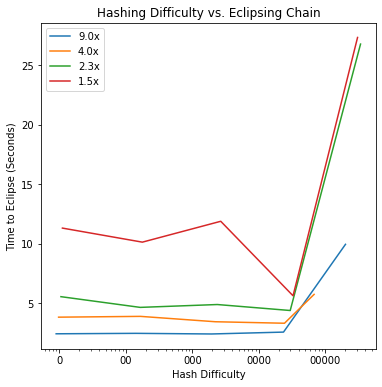

In [9]:
###### Graphs
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
 
#x=np.arange(6)
 
#GThread = [[1, 1.2315163612365723, 2.948852300643921, 3.889847755432129, 2.9403350353240967, 2.621577024459839, 1.1566028594970703, 1.1204774379730225, 2.7450010776519775, 2.9067327976226807, 3.2666923999786377], [2, 2.5647952556610107, 4.099946975708008, 3.6368420124053955, 3.472123622894287, 2.219743251800537, 2.33988618850708, 1.4955286979675293, 4.568793058395386, 2.914926290512085, 2.5383224487304688], [3, 2.8037335872650146, 6.869351387023926, 3.754425048828125, 3.6185522079467773, 4.053433179855347, 2.416022539138794, 4.221527814865112, 5.037161350250244, 12.472448825836182, 6.503695487976074], [4, 9.828530311584473, 5.531847953796387, 5.835397958755493, 17.003570318222046, 5.956476211547852, 11.817822694778442, 4.468087434768677, 44.156479597091675, 4.663335561752319, 6.395544528961182], [5], [6]]

fig=plt.figure()
fig = plt.gcf()
fig.set_size_inches(6,6)
ax=fig.add_subplot(111)
ax.set_xscale('log')

plt.xlabel("Hash Difficulty")
plt.xticks([0.0001,0.001,0.01,.1, 1],["0","00","000","0000","00000"])
plt.ylabel("Time to Eclipse (Seconds)")
plt.title("Hashing Difficulty vs. Eclipsing Chain")

lines = {1:[],2:[],3:[],4:[]}
times = {1:[],2:[],3:[],4:[]}

for key in DifThreads:
    GThread, GenTime = DifThreads[key]
    for i in GThread:
        if(i[0] > NumGThreads): continue
        thAvg = np.average(i[1:])
       # print(GenTime[i[0]])
        gnAvg = np.average(GenTime[i[0]][1:])
        #print(key, gnAvg, thAvg)
        #print(lines[i[0]], i[0], thAvg)
        lines[i[0]].append(abs(thAvg))
        times[i[0]].append(abs(gnAvg))

            
for key in lines:
    #print(lines[key], times[key])
    plt.plot(times[key], lines[key],label = "%sx"%round((10-key)/key, 1))
#plt.scatter(gnAvg,thAvg)#, label = "%d Good Thread(s)"%(i[0]-1))

plt.legend(loc=2)
plt.show()
fig.savefig('hashDiff.png', dpi=100)

In [70]:
DifThreads = {0: ([[1, 2.9450836181640625, 3.541233539581299, 1.8038716316223145, 3.118910789489746, 2.939255475997925, 3.294100284576416, 4.254430055618286, 2.0937747955322266, 1.6295764446258545], [2, 4.589921236038208, 2.2640528678894043, 5.179385185241699, 1.6863136291503906, 3.1641876697540283, 4.899303913116455, 2.920469045639038, 5.886003494262695, 3.61942982673645, 5.360707998275757], [3, 4.5012125968933105, 2.929893970489502, 5.454078912734985, 10.520525455474854, 5.753451585769653, 2.7523744106292725, 9.986512184143066, 6.313861608505249, 6.602979898452759, 3.3791961669921875], [4, 13.204683780670166, 22.441229581832886, 13.125894546508789, 6.959149122238159, 7.873528718948364, 10.248024463653564, 26.03640365600586, 5.3584113121032715, 4.388317346572876, 2.8212108612060547], [5], [6]], [[1], [2, 0.18580298674734017, 0.2685542387120864, 0.10930705070495605, 0.2777646700541178, 0.20873535596407378, 0.16464008225335014, 0.36588768525557086, 0.14242007182194635, 0.1063873291015625], [3, 0.2986711025238037, 0.18019967079162597, 0.342270713103445, 0.1619127897115854, 0.2334905587709867, 0.45472344230203066, 0.2554915327774851, 0.2857497244170218, 0.20425281701264558, 0.3551779747009277], [4, 0.37994731267293297, 0.2311702195335837, 0.3654592418670654, 0.3836577468448215, 0.38327077865600584, 0.1782853603363037, 0.3225381748349059, 0.2861087240021804, 0.4068233344865882, 0.3944005749442361], [5, 0.35411929728379893, 0.3718201426772384, 0.3258620708707779, 0.3183380762736003, 0.2912101523820744, 0.2960179563154254, 0.5592694684360804, 0.2703121503194173, 0.34401551414938536, 0.23652968406677247], [6]]), 5: ([[1, 1.2513668537139893, 1.179227590560913, 0.8866677284240723, 1.002526044845581, 0.9808697700500488, 1.3059697151184082, 1.0414559841156006, 2.0889339447021484, 0.7723293304443359, 1.251265048980713], [2, 1.67326021194458, 2.5200858116149902, 0.32535743713378906, 1.1772480010986328, 1.0717296600341797, 1.4706261157989502, 1.0110523700714111, 1.3182904720306396, 0.9499387741088867, 1.5781819820404053], [3, 1.6680982112884521, 2.3437116146087646, 2.08467960357666, 3.4046216011047363, 1.666097640991211, 1.4695656299591064, 1.812309980392456, 1.7191035747528076, 1.3990998268127441, 1.7325823307037354], [4, 2.138129711151123, 1.8020827770233154, 1.5286686420440674, 1.585975170135498, 1.9559078216552734, 2.6074275970458984, 2.071699619293213, 2.1860554218292236, 1.4669852256774902, 2.1707382202148438], [5], [6]], [[1], [2, 0.026409467061360676, 0.01876680056254069, 0.01650412877400716, 0.008639812469482422, 0.0, 0.1140147050221761, 0.0012355645497639973, 0.20462997754414877, 0.021074692408243816, 0.05228106180826823], [3, 0.20069422721862792, 0.2580568790435791, 0.052744483947753905, 0.059000253677368164, 0.09881119728088379, 0.13889317512512206, 0.16181282997131347, 0.14168949127197267, 0.06596083641052246, 0.10217933654785157], [4, 0.1470767089298793, 0.18613692692347936, 0.2312617301940918, 0.3947173867906843, 0.14559173583984375, 0.13840532302856445, 0.17282625607081822, 0.09343998772757393, 0.11721226147242955, 0.14245479447501047], [5, 0.22381824917263454, 0.12584304809570312, 0.23021113872528076, 0.24551661809285483, 0.19191323386298287, 0.20726301934983996, 0.16765975952148438, 0.08204600546095106, 0.09842080540127224, 0.22293312208993094], [6]]), 10: ([[1, 1.31290864944458, 1.5835747718811035, 1.2781028747558594, 2.03694486618042, 1.232208490371704, 1.0824666023254395, 1.1847851276397705, 1.193004846572876, 1.7508587837219238, 0.7116820812225342], [2, 1.1822304725646973, 1.5359721183776855, 0.847205638885498, 1.5696845054626465, 1.343102216720581, 2.612081527709961, 1.487699270248413, 1.2459254264831543, 0.5257472991943359], [3, 1.6957426071166992, 1.4550600051879883, 0.778660774230957, 1.7683510780334473, 2.1007981300354004, 1.9657070636749268, 0.9241070747375488, 0.9227843284606934, 1.1292271614074707, 1.5281519889831543], [4, 2.0602285861968994, 2.203843593597412, 4.180807828903198, 2.0678622722625732, 1.318147897720337, 2.931675672531128, 2.0586862564086914, 2.6694440841674805, 3.7406606674194336, 2.602609872817993], [5], [6]], [[1], [2, 0.0908525784810384, 0.19509808222452799, 0.044067700703938804, 0.11661052703857422, 0.001959641774495443, 0.04415543874104818, 0.012310266494750977, 0.03563229242960612, 0.23457964261372885, 0.05650575955708822], [3, 0.040244436264038085, 0.08423237800598145, 0.0360166072845459, 0.06944293975830078, 0.14645190238952638, 0.3048572063446045, 0.12523999214172363, 0.0408015251159668, 0.0647613525390625], [4, 0.07950803211757115, 0.057496888296944756, 0.09468412399291992, 0.12127280235290527, 0.20904203823634557, 0.19483273369925364, 0.1540088653564453, 0.022998491923014324, 0.08056609971182686, 0.13011268207005092], [5, 0.14668350749545628, 0.22114941052028111, 0.4094635115729438, 0.20164807637532553, 0.163440431867327, 0.20845627784729004, 0.12120178010728624, 0.09839492373996311, 0.26950881216261124, 0.20459847980075413], [6]]), 15: ([[1, 2.242164373397827, 1.3304812908172607, 1.3571715354919434, 0.5461874008178711, 1.3955998420715332, 1.2960412502288818, 1.7766945362091064, 1.237851619720459, 1.067237377166748, 1.5160207748413086], [2, 1.8006031513214111, 1.6362817287445068, 2.1704795360565186, 1.9665699005126953, 3.0716392993927, 1.2643373012542725, 2.1016762256622314, 1.9632790088653564, 1.9799182415008545], [3, 1.3502366542816162, 1.6025547981262207, 1.3210198879241943, 2.3365230560302734, 2.088231325149536, 1.0360000133514404, 1.263188362121582, 1.091477394104004, 1.6947736740112305, 1.4243664741516113], [4, 2.4828972816467285, 1.3360180854797363, 2.0733187198638916, 1.334050178527832, 2.5737133026123047, 2.1289258003234863, 2.3148906230926514, 1.7193660736083984, 1.3773446083068848, 2.2671213150024414], [5], [6]], [[1], [2, 0.26450419425964355, 0.0, 0.10903247197469075, 0.016322930653889973, 0.07968688011169434, 0.1531363328297933, 0.027518590291341145, 0.0037255287170410156, 0.07443586985270183, 0.027650912602742512], [3, 0.21914172172546387, 0.14894676208496094, 0.10530972480773926, 0.13420934677124025, 0.39975671768188475, 0.11010351181030273, 0.1279005527496338, 0.214280366897583, 0.20396132469177247], [4, 0.16137351308550155, 0.1809600761958531, 0.1448697362627302, 0.19031998089381627, 0.2580468314034598, 0.22294650077819825, 0.1497527531215123, 0.0804821423121861, 0.19274844442095077, 0.1878631455557687], [5, 0.13781680001152885, 0.1833557060786656, 0.21479399998982748, 0.08403331892830986, 0.2143433623843723, 0.17375559277004665, 0.15538936191134983, 0.14586363898383248, 0.1392207145690918, 0.20920937401907785], [6]]), 20: ([[1, 2.031132698059082, 0.9453082084655762, 1.6281251907348633, 1.132655382156372, 1.5843853950500488, 2.018749475479126, 1.396583080291748, 0.8735599517822266, 2.271150588989258, 0.8016729354858398], [2, 1.773608922958374, 1.3618898391723633, 0.8216426372528076, 1.6293017864227295, 2.9348549842834473, 1.7263872623443604, 1.674560546875, 1.2940428256988525, 2.0758965015411377, 1.8653576374053955], [3, 1.2627325057983398, 1.888059377670288, 1.7550835609436035, 2.0352914333343506, 2.2836503982543945, 1.812107801437378, 1.907451868057251, 1.606374979019165, 1.278433084487915, 1.1741142272949219], [4, 2.6519546508789062, 1.8237597942352295, 2.237638473510742, 2.1646153926849365, 1.951096773147583, 1.3818988800048828, 2.2572014331817627, 1.4703409671783447, 2.1285977363586426, 0.61820387840271], [5], [6]], [[1], [2, 0.22011788686116537, 0.03365333875020345, 0.14533209800720215, 0.014001290003458658, 0.06229178110758463, 0.23326484362284342, 0.09071071942647298, 0.053448756535847984, 0.2459723949432373, 0.0], [3, 0.0946474552154541, 0.12757118542989096, 0.09330477714538574, 0.17969560623168945, 0.34900102615356443, 0.13436436653137207, 0.12225241661071777, 0.05620217323303223, 0.1888803482055664, 0.1573361873626709], [4, 0.05686075346810477, 0.20108366012573242, 0.11248537472316197, 0.18039846420288086, 0.1781597478049142, 0.07610995428902763, 0.08798016820635114, 0.15434183393205916, 0.22933745384216309, 0.021140019098917644], [5, 0.26021893819173175, 0.12147092819213867, 0.19309698210822213, 0.31680334938897026, 0.1797951857248942, 0.11996438768174914, 0.14201317893134224, 0.1526153882344564, 0.20723414421081543, 0.05286908149719238], [6]])}


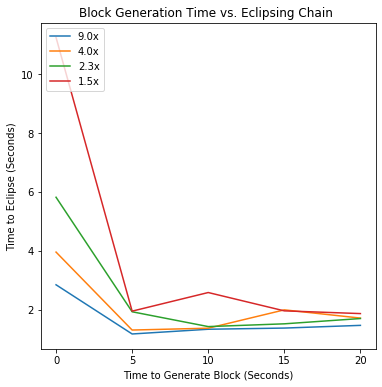

In [72]:
###### Graphs
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
 
#x=np.arange(6)
 
#GThread = [[1, 1.2315163612365723, 2.948852300643921, 3.889847755432129, 2.9403350353240967, 2.621577024459839, 1.1566028594970703, 1.1204774379730225, 2.7450010776519775, 2.9067327976226807, 3.2666923999786377], [2, 2.5647952556610107, 4.099946975708008, 3.6368420124053955, 3.472123622894287, 2.219743251800537, 2.33988618850708, 1.4955286979675293, 4.568793058395386, 2.914926290512085, 2.5383224487304688], [3, 2.8037335872650146, 6.869351387023926, 3.754425048828125, 3.6185522079467773, 4.053433179855347, 2.416022539138794, 4.221527814865112, 5.037161350250244, 12.472448825836182, 6.503695487976074], [4, 9.828530311584473, 5.531847953796387, 5.835397958755493, 17.003570318222046, 5.956476211547852, 11.817822694778442, 4.468087434768677, 44.156479597091675, 4.663335561752319, 6.395544528961182], [5], [6]]

fig=plt.figure()
ax=fig.add_subplot(111)
#ax.set_xscale('log')
fig.set_size_inches(6,6)


plt.xticks([0,5,10,15,20],["0","5","10","15","20"])
plt.xlabel("Time to Generate Block (Seconds)")
plt.ylabel("Time to Eclipse (Seconds)")
plt.title("Block Generation Time vs. Eclipsing Chain ")

lines = {1:[],2:[],3:[],4:[]}
times = {1:[],2:[],3:[],4:[]}

for key in DifThreads:
    GThread, GenTime = DifThreads[key]
    for i in GThread:
        if(i[0] > NumGThreads): continue
        thAvg = np.average(i[1:])
       # print(GenTime[i[0]])
        gnAvg = np.average(GenTime[i[0]][1:])
        #print(key, gnAvg, thAvg)
        #print(lines[i[0]], i[0], thAvg)
        lines[i[0]].append(thAvg)
        times[i[0]].append(key)

            
for key in lines:
    #print(lines[key], times[key])
    plt.plot(times[key], lines[key],label = "%sx"%round((10-key)/key, 1))
#plt.scatter(gnAvg,thAvg)#, label = "%d Good Thread(s)"%(i[0]-1))

plt.legend(loc=2)
plt.show()
fig.savefig('blockTime.png', dpi=100)

In [24]:
DifThreads = 

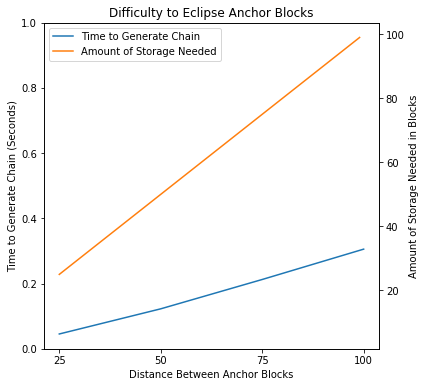

In [1]:
###### Graphs
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
 
#x=nparange(6)
 

fig=plt.figure()
ax=fig.add_subplot(111)
fig.set_size_inches(6,6)


plt.xticks([25,50,75,100],["25","50","75","100"])
plt.xlabel("Distance Between Anchor Blocks")
plt.ylabel("Time to Generate Chain (Seconds)")
plt.yticks
plt.title("Difficulty to Eclipse Anchor Blocks")

plt2 = plt.twinx()
plt2.set_ylabel("Amount of Storage Needed in Blocks")

lines = {25: 6.390738010406494, 50: 14.246331930160522, 75: 23.408672094345093, 100: 32.8864643573761}

          
plt.plot(list(lines.keys()),list(lines.values()), label="Time to Generate Chain")
plt2.plot(range(25,100),range(25,100), label = "Amount of Storage Needed")


plt.legend(loc=2)
plt.show()
fig.savefig('anchorDis.png', dpi=100)

No handles with labels found to put in legend.


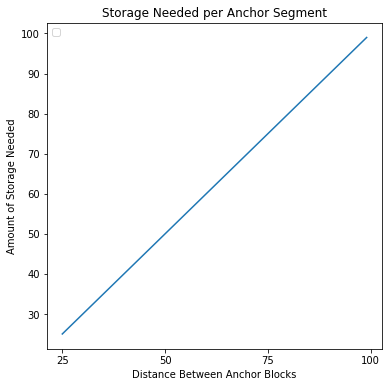

In [2]:
###### Graphs
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
 
#x=nparange(6)
 

fig=plt.figure()
ax=fig.add_subplot(111)
fig.set_size_inches(6,6)


plt.xticks([25,50,75,100],["25","50","75","100"])
plt.xlabel("Distance Between Anchor Blocks")
plt.ylabel("Amount of Storage Needed")
plt.title("Storage Needed per Anchor Segment")

        
plt.plot(range(25,100),range(25,100))

plt.legend(loc=2)
plt.show()
fig.savefig('storage.png', dpi=100)